In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from razdel import sentenize
import itertools
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [2]:
model_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

H:\Anaconda\envs\transformers\lib\site-packages\transformers\configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [23]:
#text = "Фестиваль национальных культур – самое яркое событие осени для студентов Технологического университета им. А.А. Леонова. И в этом году у него первый мини-юбилей! Пять лет как фестиваль является традиционным праздником нашего вуза и на несколько недель захватывает внимание студентов. Они активно и с энтузиазмом готовят свои выступления, продумывают сценарии и репетируют, оттачивая своё мастерство. Отличительными чертами Фестиваля национальных культур за годы его проведения стали визитные карточки разных государств, творческие номера и дегустация блюд национальной кухни. Часто именно иностранные студенты представляют свою Родину, но к процессу обязательно подключаются и другие ребята. Благодаря такому подходу студенты ещё на этапе подготовки к фестивалю погружаются в национальную культуру многих стран и делятся друг с другом своим опытом. В связи с эпидемиологической ситуацией в этом году не получилось накрыть стол с национальными блюдами, но это не помешало празднику раскрыться во всей красе через яркие информативные презентации и эффектные выступления студентов. Мероприятие прошло с соблюдением всех необходимых мер безопасности, вход осуществлялся по QR-кодам, а все желающие могли присоединиться к трансляции онлайн. В конце участники были награждены грамотами. Проректор по внеучебной и воспитательной работе Вера Минакова поблагодарила всех ребят за тот вклад, что они внесли в организацию такого яркого праздника, и отметила, что гости зарядились невероятной энергией от выступающих."
#text = "Минтранс предложил оснастить автомобили сервисов такси устройствами для контроля сонливости водителей. Об этом говорится в проекте федерального закона «О такси», размещённого на сайте проектов нормативно-правовых актов. Законопроект предусматривает, чтобы кузов такси окрашивали по схеме из квадратов контрастных цветов в шахматном порядке. При этом цветовая гамма должна «соответствовать стандартам региона». На крыше автомобиля необходимо размещать опознавательный фонарь оранжевого цвета. Если проект примут, он вступит в силу 1 сентября 2022 года. Действующие ПДД разрешают водителю находиться за рулём суммарно не более десяти часов. Контролируют это с помощью тахографов. Штраф для нарушителей — до 2,5 тысяч рублей."
text = "Сегодня в Технологическом университете им. А.А. Леонова состоялась встреча представителей компании «Первый Бит» с преподавателями вуза и студентами IT-направлений подготовки. Эта встреча – не первая. Ранее студенты уже познакомились с деятельностью компании «Первый Бит». Теперь же молодые люди узнали о возможностях трудоустройства и прохождения практики в организации. Компания заинтересована в молодых и перспективных сотрудниках. Поэтому специально для студентов её руководство разработало особые условия трудоустройства. Ребятам предлагается устроиться на работу в «Первый Бит» на вакансии с частичной занятостью, что позволит совмещать трудовую деятельность с учёбой. При успешном трудоустройстве, студенты пройдут в компании необходимое оплачиваемое обучение. Являясь сотрудниками «Первого Бита», ребята также смогут работать над своими курсовыми и дипломными проектами по тематике компании под руководством её специалистов. Многих из присутствовавших на встрече студентов заинтересовали такие перспективы, и представители «Первого Бита» сразу же предложили им пройти необходимое для трудоустройства тестирование. А остальных ребят, кто ещё не принял решение, компания с нетерпением будет ждать в своём офисе в Москве. Напомним, компания «Первый Бит» давно известна на рынке информационных услуг по автоматизации процессов учёта и управления на базе 1С. Партнёрами компании являются крупнейшие корпорации и предприятия России и ближнего зарубежья."

In [24]:
sentences = []
for sent in sentenize(text):
    sentence = {}
    sentence['text'] = sent.text
    sentence['span'] = (sent.start, sent.stop)
    sentences.append(sentence)

In [25]:
result = pd.DataFrame()

In [26]:
result1 = pd.DataFrame()
f_sentences = []
s_sentences = []
spans = []
entailments = []
contradictions = []
neutrals = []

len_sentences = int(len(sentences)*(len(sentences)-1)/2)

for first_sentence, second_sentence in tqdm(itertools.combinations(sentences, 2), total = len_sentences):
    text1 = first_sentence['text']
    text2 = second_sentence['text']
    span2 = second_sentence['span']
    with torch.inference_mode():
        out = model(**tokenizer(text1, text2, return_tensors='pt').to(model.device))
        proba = torch.softmax(out.logits, -1).cpu().numpy()[0]
    analysis = {v: proba[k] for k, v in model.config.id2label.items()}
    f_sentences.append(text1)
    s_sentences.append(text2)
    spans.append(span2)
    entailments.append(analysis['entailment'])
    contradictions.append(analysis['contradiction'])
    neutrals.append(analysis['neutral'])

result1['Previous sentence'] = f_sentences
result1['Span'] = spans
result1['Sentence'] = s_sentences
result1['Prev entailment'] = entailments
result1['Prev contradiction'] = contradictions
result1['Prev neutral'] = neutrals

100%|██████████| 66/66 [00:26<00:00,  2.51it/s]


In [27]:
result1[:5]

,Previous sentence,Span,Sentence,Prev entailment,Prev contradiction,Prev neutral
0,Сегодня в Технологическом университете им. А.А...,"(175, 199)",Эта встреча – не первая.,0.022912,0.111101,0.865987
1,Сегодня в Технологическом университете им. А.А...,"(200, 271)",Ранее студенты уже познакомились с деятельност...,0.058702,0.017497,0.923801
2,Сегодня в Технологическом университете им. А.А...,"(272, 370)",Теперь же молодые люди узнали о возможностях т...,0.315475,0.007083,0.677442
3,Сегодня в Технологическом университете им. А.А...,"(371, 433)",Компания заинтересована в молодых и перспектив...,0.245740,0.002360,0.751900
4,Сегодня в Технологическом университете им. А.А...,"(434, 525)",Поэтому специально для студентов её руководств...,0.003524,0.004611,0.991865


In [28]:
del result1['Previous sentence']

In [29]:
result1_1 = result1.groupby(['Sentence', 'Span']).mean()

In [30]:
result1_1

,,Prev entailment,Prev contradiction,Prev neutral
Sentence,Span,,,
"А остальных ребят, кто ещё не принял решение, компания с нетерпением будет ждать в своём офисе в Москве.","(1121, 1225)",0.002333,0.089110,0.908556
Компания заинтересована в молодых и перспективных сотрудниках.,"(371, 433)",0.128547,0.003420,0.868034
"Многих из присутствовавших на встрече студентов заинтересовали такие перспективы, и представители «Первого Бита» сразу же предложили им пройти необходимое для трудоустройства тестирование.","(932, 1120)",0.002388,0.013686,0.983927
"Напомним, компания «Первый Бит» давно известна на рынке информационных услуг по автоматизации процессов учёта и управления на базе 1С. Партнёрами компании являются крупнейшие корпорации и предприятия России и ближнего зарубежья.","(1226, 1454)",0.002292,0.007084,0.990624
Поэтому специально для студентов её руководство разработало особые условия трудоустройства.,"(434, 525)",0.002165,0.005675,0.992161
"При успешном трудоустройстве, студенты пройдут в компании необходимое оплачиваемое обучение.","(674, 766)",0.015372,0.020128,0.964499
Ранее студенты уже познакомились с деятельностью компании «Первый Бит».,"(200, 271)",0.034609,0.012068,0.953323
"Ребятам предлагается устроиться на работу в «Первый Бит» на вакансии с частичной занятостью, что позволит совмещать трудовую деятельность с учёбой.","(526, 673)",0.010967,0.029800,0.959233
Теперь же молодые люди узнали о возможностях трудоустройства и прохождения практики в организации.,"(272, 370)",0.112820,0.015943,0.871238


In [31]:
columns = ['Sentence', 'Prev text', 'Entailment', 'Contradiction', 'Neutral']
result2 = pd.DataFrame(columns=columns)

for sentence in tqdm(sentences):
    prev_text = ''
    for prev_sentence in sentences[:sentences.index(sentence)]:
        prev_text += prev_sentence['text']
    
    with torch.inference_mode():
        out = model(**tokenizer(prev_text, sentence['text'], return_tensors='pt').to(model.device))
        proba = torch.softmax(out.logits, -1).cpu().numpy()[0]
    analysis = {v: proba[k] for k, v in model.config.id2label.items()}
    
    entailments.append(analysis['entailment'])
    contradictions.append(analysis['contradiction'])
    neutrals.append(analysis['neutral'])
        
    new_df = pd.DataFrame([
        [sentence['text'], 
         prev_text, 
         analysis['entailment'], 
         analysis['contradiction'], 
         analysis['neutral']
        ]], columns = columns)
    result2 = result2.append(new_df)

result2 = result2.reset_index(drop=True)

100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


(array([1., 0., 0., 1., 2., 0., 1., 2., 1., 4.]),
 array([0.1492842 , 0.23325959, 0.31723498, 0.40121037, 0.48518576,
        0.56916115, 0.65313655, 0.73711194, 0.82108733, 0.90506272,
        0.98903811]),
 <BarContainer object of 10 artists>)

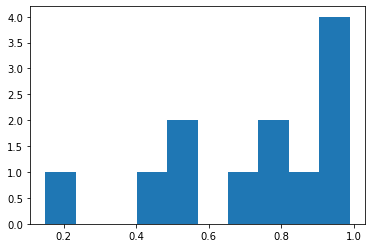

In [32]:
plt.hist(result2['Neutral'])

In [34]:
del result2['Prev text']

In [33]:
result2['Max'] = result2[['Entailment','Contradiction','Neutral']].idxmax(axis=1)

In [35]:
result2

,Sentence,Entailment,Contradiction,Neutral,Max
0,Сегодня в Технологическом университете им. А.А...,0.003123,0.007839,0.989038,Neutral
1,Эта встреча – не первая.,0.022912,0.111101,0.865987,Neutral
2,Ранее студенты уже познакомились с деятельност...,0.206707,0.021263,0.772029,Neutral
3,Теперь же молодые люди узнали о возможностях т...,0.336199,0.113163,0.550638,Neutral
4,Компания заинтересована в молодых и перспектив...,0.488943,0.002773,0.508283,Neutral
5,Поэтому специально для студентов её руководств...,0.014199,0.007509,0.978293,Neutral
6,Ребятам предлагается устроиться на работу в «П...,0.828829,0.021887,0.149284,Entailment
7,"При успешном трудоустройстве, студенты пройдут...",0.176162,0.027450,0.796387,Neutral
8,"Являясь сотрудниками «Первого Бита», ребята та...",0.055902,0.002377,0.941721,Neutral
9,Многих из присутствовавших на встрече студенто...,0.204496,0.365097,0.430407,Neutral


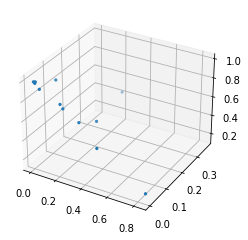

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(result2['Entailment'], result2['Contradiction'], result2['Neutral'], s=5)

In [38]:
pca=PCA(n_components=2)
pca_result = pca.fit_transform(result2[['Entailment', 'Contradiction', 'Neutral']])
pca_df = pd.DataFrame(pca_result, columns=['x', 'y'])

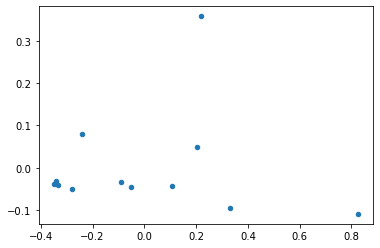

In [39]:
plt.scatter(pca_df['x'], pca_df['y'], s=20)

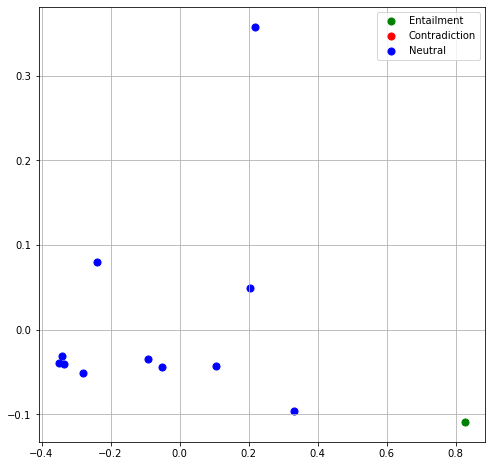

In [40]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

targets = ['Entailment', 'Contradiction', 'Neutral']
colors = ['g', 'r', 'b']
markers = ['o', 'o', 'o']

for target, color, marker in zip(targets,colors,markers):
    indicesToKeep = result2['Max'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'x']
               , pca_df.loc[indicesToKeep, 'y']
               , c = color
               , s = 50
               , marker = marker
              )
ax.legend(targets)
ax.grid()

In [41]:
pca.explained_variance_ratio_

array([0.89130316, 0.10869684])